# ノートブック11: モデル比較と選択

## 学習目標

このノートブックでは、複数の機械学習モデルを体系的に比較し、最適なモデルを選択する手法を学びます:

1. **公平な比較**
   - クロスバリデーション
   - 同じデータ分割
   - 標準化された評価指標

2. **統計的検定**
   - t検定による有意差の検証
   - モデル間の性能差

3. **アンサンブル手法**
   - Voting (Hard/Soft)
   - Stacking
   - 性能向上の仕組み

4. **選択基準**
   - 性能 vs 解釈性
   - 訓練時間 vs 予測時間
   - 過学習のリスク

5. **実践的な意思決定**
   - ビジネス要件
   - 運用制約
   - コストベネフィット分析

---

## セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, f1_score
)
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
np.random.seed(42)

print("Setup complete!")

Setup complete!


---

## 1. データセットとベースライン

In [2]:
# データ生成
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=15,
    n_redundant=3,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)}, Test: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

# ベースライン: ランダム予測
baseline_accuracy = max(np.bincount(y_train)) / len(y_train)
print(f"\nBaseline (majority class): {baseline_accuracy:.4f}")

Training: 1600, Test: 400
Features: 20
Classes: 3

Baseline (majority class): 0.3350


---

## 2. モデル定義と初期評価

In [3]:
# 比較するモデルを定義
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, 
                         early_stopping=True, random_state=42)
}

print(f"Comparing {len(models)} models")
print("\nModel List:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")

Comparing 8 models

Model List:
  1. Logistic Regression
  2. KNN
  3. Naive Bayes
  4. Decision Tree
  5. Random Forest
  6. Gradient Boosting
  7. SVM
  8. MLP


### クロスバリデーションによる比較

In [4]:
# 10-fold クロスバリデーション
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = {}
cv_scores = {}
training_times = {}

print("Cross-Validation Results (10-fold):")
print("="*70)

for name, model in models.items():
    # 訓練時間の測定
    start_time = time.time()
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    train_time = time.time() - start_time
    
    cv_scores[name] = scores
    training_times[name] = train_time
    
    results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max(),
        'time': train_time
    }
    
    print(f"{name:22s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Time: {train_time:.2f}s")

# ランキング
sorted_results = sorted(results.items(), key=lambda x: x[1]['mean'], reverse=True)

print("\nRanking by CV Accuracy:")
print("="*70)
for rank, (name, res) in enumerate(sorted_results, 1):
    print(f"{rank:2d}. {name:22s}: {res['mean']:.4f} (+/- {res['std']:.4f})")

Cross-Validation Results (10-fold):
Logistic Regression   : 0.6969 (+/- 0.0222) | Time: 0.08s


KNN                   : 0.8719 (+/- 0.0210) | Time: 0.25s
Naive Bayes           : 0.6750 (+/- 0.0332) | Time: 0.02s


Decision Tree         : 0.6469 (+/- 0.0278) | Time: 0.20s


Random Forest         : 0.8481 (+/- 0.0190) | Time: 4.31s


Gradient Boosting     : 0.8088 (+/- 0.0231) | Time: 21.76s


SVM                   : 0.9181 (+/- 0.0252) | Time: 2.28s


MLP                   : 0.9012 (+/- 0.0185) | Time: 3.68s

Ranking by CV Accuracy:
 1. SVM                   : 0.9181 (+/- 0.0252)
 2. MLP                   : 0.9012 (+/- 0.0185)
 3. KNN                   : 0.8719 (+/- 0.0210)
 4. Random Forest         : 0.8481 (+/- 0.0190)
 5. Gradient Boosting     : 0.8088 (+/- 0.0231)
 6. Logistic Regression   : 0.6969 (+/- 0.0222)
 7. Naive Bayes           : 0.6750 (+/- 0.0332)
 8. Decision Tree         : 0.6469 (+/- 0.0278)


### 結果の可視化

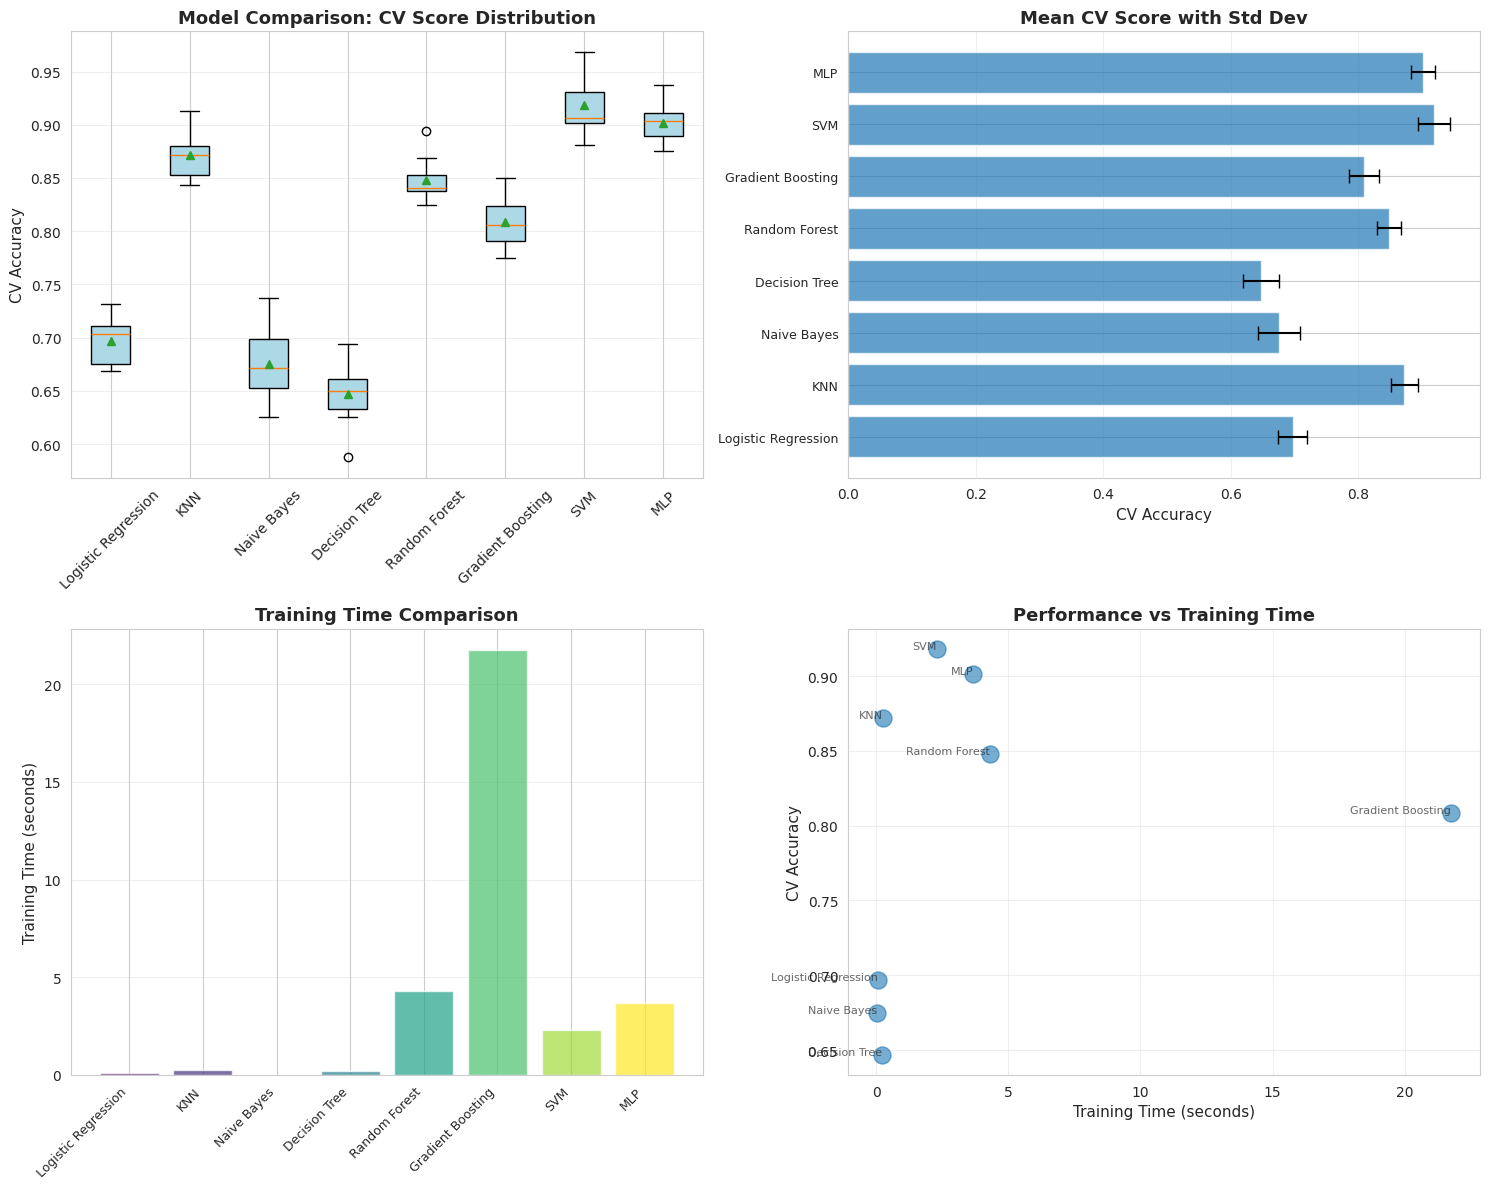


Key Observations:
- Top-right in performance/time plot: Best tradeoff
- Low variance across folds: More stable model
- Fast training: Better for iterative development


In [5]:
# CV結果の包括的な可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ボックスプロット
names = list(cv_scores.keys())
scores_list = [cv_scores[name] for name in names]

bp = axes[0, 0].boxplot(scores_list, labels=names, patch_artist=True, showmeans=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 0].set_ylabel('CV Accuracy', fontsize=11)
axes[0, 0].set_title('Model Comparison: CV Score Distribution', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. 平均スコアとエラーバー
means = [results[name]['mean'] for name in names]
stds = [results[name]['std'] for name in names]
x_pos = np.arange(len(names))

axes[0, 1].barh(x_pos, means, xerr=stds, capsize=5, alpha=0.7)
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(names, fontsize=9)
axes[0, 1].set_xlabel('CV Accuracy', fontsize=11)
axes[0, 1].set_title('Mean CV Score with Std Dev', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. 訓練時間
times = [training_times[name] for name in names]
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
axes[1, 0].bar(range(len(names)), times, color=colors, alpha=0.7)
axes[1, 0].set_xticks(range(len(names)))
axes[1, 0].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
axes[1, 0].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. 性能 vs 訓練時間
axes[1, 1].scatter(times, means, s=150, alpha=0.6)
for i, name in enumerate(names):
    axes[1, 1].annotate(name, (times[i], means[i]), 
                        fontsize=8, ha='right', alpha=0.7)
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=11)
axes[1, 1].set_ylabel('CV Accuracy', fontsize=11)
axes[1, 1].set_title('Performance vs Training Time', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Top-right in performance/time plot: Best tradeoff")
print("- Low variance across folds: More stable model")
print("- Fast training: Better for iterative development")

---

## 3. 統計的有意性検定

モデル間の性能差が統計的に有意かを検証します。

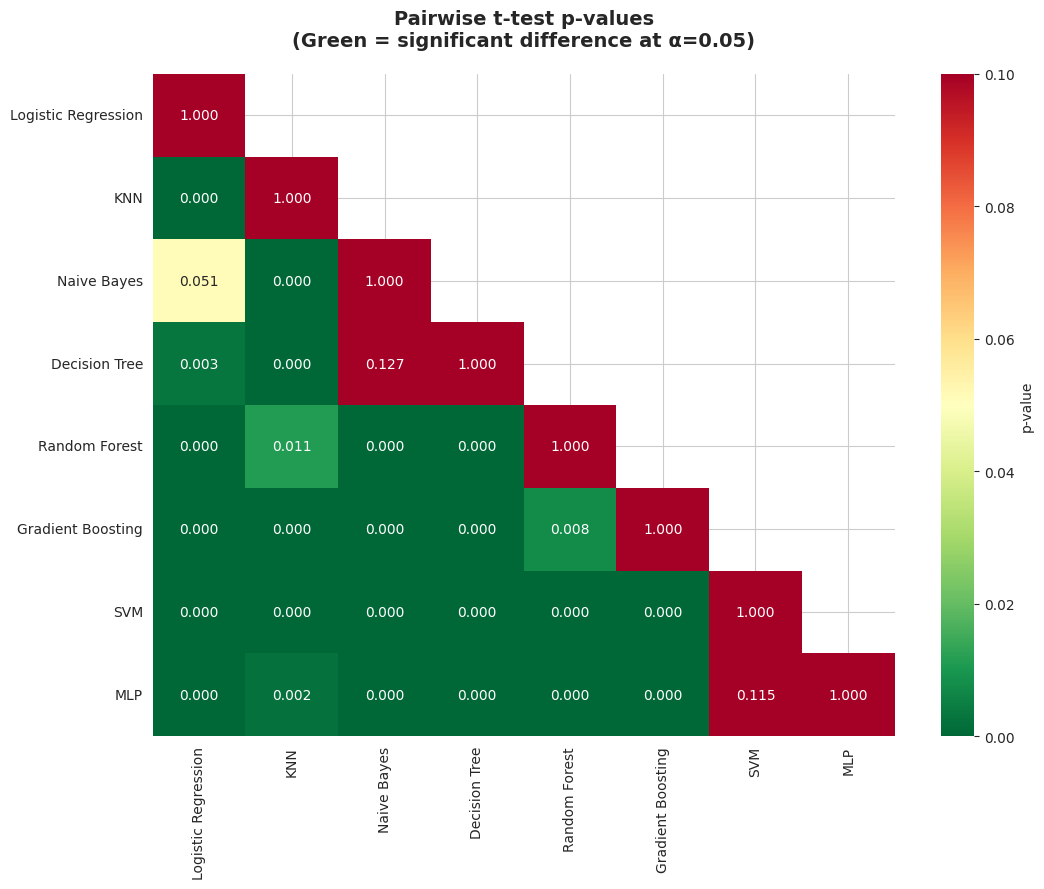


Interpretation:
- p < 0.05: Statistically significant difference (green)
- p > 0.05: No significant difference (red)

Significant pairs:
  Logistic Regression vs KNN: p=0.0000 → KNN is better
  Logistic Regression vs Decision Tree: p=0.0029 → Logistic Regression is better
  Logistic Regression vs Random Forest: p=0.0000 → Random Forest is better
  Logistic Regression vs Gradient Boosting: p=0.0000 → Gradient Boosting is better
  Logistic Regression vs SVM: p=0.0000 → SVM is better
  Logistic Regression vs MLP: p=0.0000 → MLP is better
  KNN vs Naive Bayes: p=0.0000 → KNN is better
  KNN vs Decision Tree: p=0.0000 → KNN is better
  KNN vs Random Forest: p=0.0110 → KNN is better
  KNN vs Gradient Boosting: p=0.0002 → KNN is better
  KNN vs SVM: p=0.0002 → SVM is better
  KNN vs MLP: p=0.0023 → MLP is better
  Naive Bayes vs Random Forest: p=0.0000 → Random Forest is better
  Naive Bayes vs Gradient Boosting: p=0.0000 → Gradient Boosting is better
  Naive Bayes vs SVM: p=0.0000 → SVM is 

In [6]:
# ペアワイズt検定
model_names = list(cv_scores.keys())
n_models = len(model_names)

p_values = np.ones((n_models, n_models))

for i in range(n_models):
    for j in range(i+1, n_models):
        # 対応のあるt検定
        t_stat, p_value = stats.ttest_rel(cv_scores[model_names[i]], 
                                          cv_scores[model_names[j]])
        p_values[i, j] = p_value
        p_values[j, i] = p_value

# ヒートマップで可視化
plt.figure(figsize=(11, 9))
mask = np.triu(np.ones_like(p_values, dtype=bool), k=1)
sns.heatmap(p_values, annot=True, fmt='.3f', cmap='RdYlGn_r',
            xticklabels=model_names, yticklabels=model_names,
            mask=mask, vmin=0, vmax=0.1, cbar_kws={'label': 'p-value'})
plt.title('Pairwise t-test p-values\n(Green = significant difference at α=0.05)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- p < 0.05: Statistically significant difference (green)")
print("- p > 0.05: No significant difference (red)")
print("\nSignificant pairs:")
for i in range(n_models):
    for j in range(i+1, n_models):
        if p_values[i, j] < 0.05:
            better = model_names[i] if results[model_names[i]]['mean'] > results[model_names[j]]['mean'] else model_names[j]
            print(f"  {model_names[i]} vs {model_names[j]}: p={p_values[i, j]:.4f} → {better} is better")

---

## 4. テストセット評価

In [7]:
# すべてのモデルでテストセット評価
test_results = []

for name, model in models.items():
    # 訓練
    model.fit(X_train_scaled, y_train)
    
    # 評価
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    # 予測時間
    start_time = time.time()
    _ = model.predict(X_test_scaled)
    pred_time = time.time() - start_time
    
    test_results.append({
        'Model': name,
        'Train': train_score,
        'Test': test_score,
        'Overfit': train_score - test_score,
        'Pred_Time_ms': pred_time * 1000
    })

df_test = pd.DataFrame(test_results).sort_values('Test', ascending=False)

print("Test Set Results:")
print("="*80)
print(df_test.to_string(index=False))

print("\nOverfitting Analysis:")
print("  High overfitting (>0.10): Risk of poor generalization")
print("  Moderate (0.05-0.10): Acceptable")
print("  Low (<0.05): Good generalization")

Test Set Results:
              Model    Train   Test  Overfit  Pred_Time_ms
                MLP 0.985000 0.9100 0.075000      0.601292
                SVM 0.961250 0.9000 0.061250     16.980648
                KNN 0.922500 0.8750 0.047500      7.348299
      Random Forest 1.000000 0.8525 0.147500      9.429216
  Gradient Boosting 0.958750 0.8050 0.153750      2.914667
Logistic Regression 0.709375 0.7025 0.006875      0.109673
      Decision Tree 0.968750 0.6875 0.281250      0.129461
        Naive Bayes 0.690625 0.6775 0.013125      0.242710

Overfitting Analysis:
  High overfitting (>0.10): Risk of poor generalization
  Moderate (0.05-0.10): Acceptable
  Low (<0.05): Good generalization


---

## 5. アンサンブル手法

In [8]:
# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, 
                              early_stopping=True, random_state=42))
    ],
    voting='hard'
)

# Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,
                              early_stopping=True, random_state=42))
    ],
    voting='soft'
)

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# アンサンブルモデルの評価
print("Ensemble Methods:")
print("="*70)

ensemble_results = []
for name, model in [('Hard Voting', voting_hard), 
                    ('Soft Voting', voting_soft), 
                    ('Stacking', stacking)]:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    ensemble_results.append({
        'Method': name,
        'CV Mean': scores.mean(),
        'CV Std': scores.std(),
        'Test': test_score
    })
    
    print(f"\n{name}:")
    print(f"  CV Score:   {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Test Score: {test_score:.4f}")

df_ensemble = pd.DataFrame(ensemble_results)
print("\nEnsemble Summary:")
print(df_ensemble.to_string(index=False))

Ensemble Methods:



Hard Voting:
  CV Score:   0.8538 (+/- 0.0105)
  Test Score: 0.8675



Soft Voting:
  CV Score:   0.8681 (+/- 0.0080)
  Test Score: 0.8800



Stacking:
  CV Score:   0.9006 (+/- 0.0176)
  Test Score: 0.8875

Ensemble Summary:
     Method  CV Mean   CV Std   Test
Hard Voting 0.853750 0.010533 0.8675
Soft Voting 0.868125 0.008004 0.8800
   Stacking 0.900625 0.017611 0.8875


---

## 6. 最終モデル選択


Final Model Ranking:
              Model  CV Mean   CV Std   Test
                MLP 0.865000 0.021139 0.9100
                SVM 0.904375 0.018286 0.9000
           Stacking 0.900625 0.017611 0.8875
      Voting (Soft) 0.868125 0.008004 0.8800
                KNN 0.870625 0.018708 0.8750
      Random Forest 0.831875 0.014711 0.8525
  Gradient Boosting 0.797500 0.018477 0.8050
Logistic Regression 0.695000 0.014470 0.7025
      Decision Tree 0.619375 0.035925 0.6875
        Naive Bayes 0.675000 0.021741 0.6775

SELECTED MODEL: MLP
Test Accuracy: 0.9100
CV Accuracy:   0.8650 (+/- 0.0211)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       134
           1       0.93      0.90      0.91       134
           2       0.92      0.91      0.91       132

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



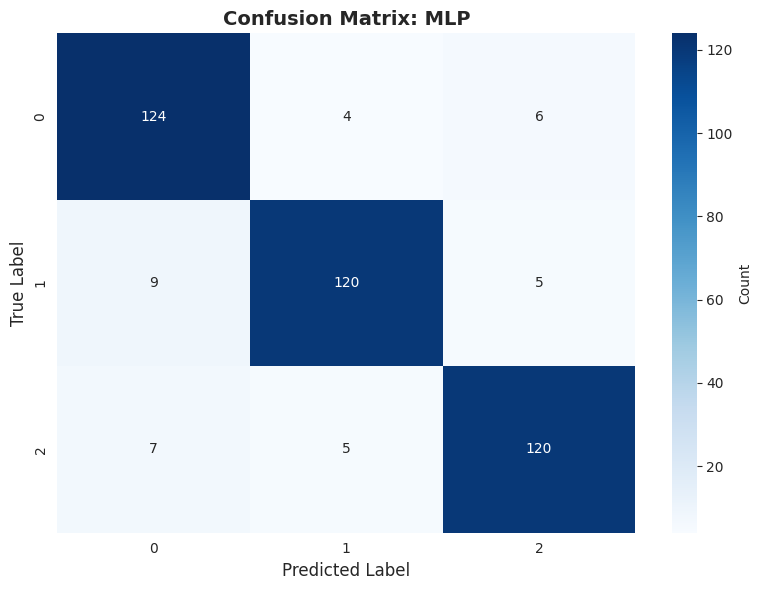

In [9]:
# すべてのモデルを統合して比較
all_models = {
    **models,
    'Voting (Soft)': voting_soft,
    'Stacking': stacking
}

final_comparison = []

for name, model in all_models.items():
    cv_scores_model = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    if not hasattr(model, 'classes_'):
        model.fit(X_train_scaled, y_train)
    
    test_score = model.score(X_test_scaled, y_test)
    
    final_comparison.append({
        'Model': name,
        'CV Mean': cv_scores_model.mean(),
        'CV Std': cv_scores_model.std(),
        'Test': test_score
    })

df_final = pd.DataFrame(final_comparison).sort_values('Test', ascending=False)

print("\nFinal Model Ranking:")
print("="*70)
print(df_final.to_string(index=False))

# 最良モデルの選択
best_model_name = df_final.iloc[0]['Model']
best_model = all_models[best_model_name]

print(f"\n" + "="*70)
print(f"SELECTED MODEL: {best_model_name}")
print("="*70)
print(f"Test Accuracy: {df_final.iloc[0]['Test']:.4f}")
print(f"CV Accuracy:   {df_final.iloc[0]['CV Mean']:.4f} (+/- {df_final.iloc[0]['CV Std']:.4f})")

# 詳細な評価
y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 混同行列
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## まとめ

### モデル選択の要点

1. **公平な比較**
   - 同じデータ分割
   - クロスバリデーション
   - 標準化された前処理

2. **統計的検定**
   - 性能差の有意性を確認
   - 小さな差は無視する

3. **アンサンブル**
   - Voting: 多数決
   - Stacking: メタ学習
   - 通常、単一モデルより良い

4. **選択基準**
   - **性能**: 最優先
   - **安定性**: CVの標準偏差
   - **過学習**: Train-Testギャップ
   - **速度**: 訓練・予測時間
   - **解釈性**: ビジネス要件

5. **実践的考慮事項**
   - 運用コスト
   - メンテナンス性
   - スケーラビリティ
   - 説明可能性

### 意思決定フレームワーク

```
IF 解釈性が重要:
    → Logistic Regression, Decision Tree
ELSE IF 性能最優先:
    → Ensemble Methods, MLP
ELSE IF 高速予測が必要:
    → Random Forest, KNN
ELSE IF バランス重視:
    → Gradient Boosting, SVM
```

---

**次のステップ**: ノートブック12で、完全なMLパイプラインを構築し、本番環境へのデプロイを準備します!
